In [1]:
import pytz
import os
import sqlite3
import re
import uproot
import IPython
import sys
import numpy as np
import pandas as pd
import pymap3d as pm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pandasql import sqldf
from rnog_data.runtable import RunTable
from datetime import datetime, timedelta
from NuRadioReco.modules.io.RNO_G.readRNOGDataMattak import readRNOGData
from NuRadioReco.utilities import units
from scipy.signal import hilbert
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyArrowPatch

from IPython.display import clear_output

from Flight import Flight


In [5]:
'''
reader = readRNOGData()

reader.begin([f'/home/oliver/software/Flights/combined_handcarry/station11/run1313'], overwrite_sampling_rate=3200*units.MHz, apply_baseline_correction='approximate')

channel_number = 13
for i in range(4773):
    event = reader.get_event_by_index(i)
    station = event.get_station()
    channel = station.get_channel(channel_number)
    trace = channel.get_trace()
    plt.plot(trace)
    plt.savefig(f'./test_traces/channel_{channel_number}_{i}.png')
    plt.close()
    print(i)
'''
''

''

# l1

INFO:NuRadioReco.readRNOGData:Set 0 selector(s)
INFO:NuRadioReco.readRNOGData:Parse through / read-in 1 directory(ies) / file(s).
INFO:NuRadioReco.readRNOGData:4773 events in 1 runs/datasets have been found using the uproot Mattak backend.


Using uproot backend
Open waveforms.root (Found full run folder) ...
event_nr:  534
0.516971686711363
f: 0.1234375 amp:  29.9706713012913 l1:  0.516971686711363


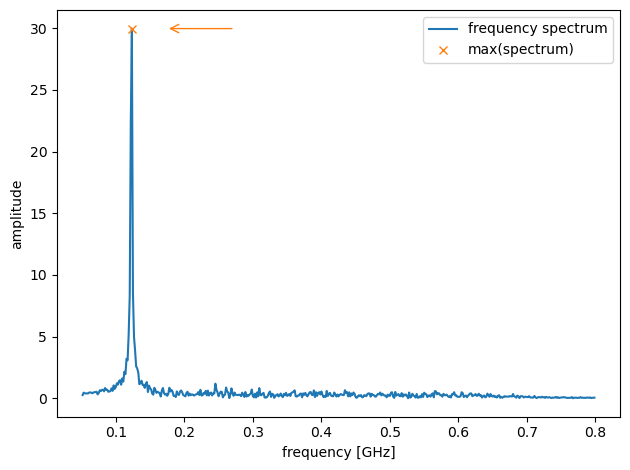

In [4]:
reader = readRNOGData()

reader.begin([f'/home/oliver/software/Flights/combined_handcarry/station11/run1313'], overwrite_sampling_rate=3200*units.MHz, apply_baseline_correction='approximate')
event = reader.get_event_by_index(534)
print('event_nr: ', event.get_id())
station = event.get_station()

channel_number = 13

channel = station.get_channel(channel_number)
full_trace = channel.get_trace()
freq = channel.get_frequencies()
mask  = (0.05 < freq) & (freq < 0.8) & (freq != 0.2)
freq = freq[mask]
spectrum = np.abs(channel.get_frequency_spectrum())
l1 = Flight.simple_l1(spectrum)
print(l1)
spectrum = spectrum[mask]

fig, ax = plt.subplots()
ax.plot(freq, spectrum, label = 'frequency spectrum')


ymax_index = np.argmax(spectrum)
ax.plot(freq[ymax_index], spectrum[ymax_index], 'x', color = 'C1', label = 'max(spectrum)')

print('f:', freq[ymax_index], 'amp: ', spectrum[ymax_index], 'l1: ', l1)

# Add a nicer-looking arrow
arrow = FancyArrowPatch(
    (freq[ymax_index] + 0.15, spectrum[ymax_index]),  # Starting point of the arrow
    (freq[ymax_index] + 0.05, spectrum[ymax_index]),   # Ending point of the arrow
    color='C1', 
    arrowstyle='->', 
    mutation_scale=15  # Size of the arrow head
)
fig.gca().add_patch(arrow)

xlabel = 'frequency [GHz]'
ylabel = 'amplitude'

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.legend()
plt.tight_layout()
#fig.savefig('/home/oliver/thesis/figures/scores/l1.pdf')

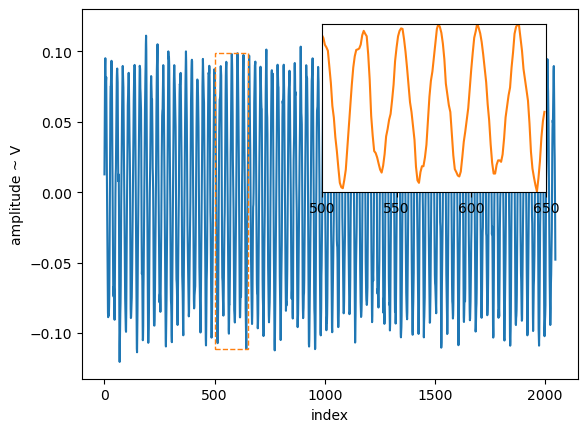

<Figure size 640x480 with 0 Axes>

In [117]:
trace = full_trace
# Define the zoom window
start_idx = 500
rect_width = 150
end_idx = start_idx + rect_width

# Create the main plot
fig, ax = plt.subplots()

# Plot the full trace
xlabel = 'index'
ylabel = 'amplitude ~ V'

ax.plot(trace, zorder=1, label='trace')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# Create an inset for the zoom window
ax_inset = fig.add_axes([0.5, 0.5, 0.35, 0.35])  # Position of the inset plot [x, y, width, height]
ax_inset.plot(trace[start_idx:end_idx], color='C1')
ax_inset.set_xticks([0, 50, 100, 150])
ax_inset.set_xticklabels([start_idx, start_idx + 50, start_idx + 100, end_idx])

ax_inset.set_yticks([])

ax_inset.set_xlim([0, rect_width])
ax_inset.set_ylim([np.min(trace[start_idx:end_idx]), np.max(trace[start_idx:end_idx])])



# Draw a rectangle on the main plot to indicate the zoom-in area
#rect = plt.Rectangle((start_idx, np.min(trace)), 100, np.max(trace[start_idx:end_idx]) - np.min(trace[start_idx:end_idx]),
rect = plt.Rectangle((start_idx, np.min(trace[start_idx:end_idx])), rect_width, np.max(trace[start_idx:end_idx]) - np.min(trace[start_idx:end_idx]), 
                     color='C1', zorder=2, fill=False, linestyle='--')
ax.add_patch(rect)

#plt.legend()
#plt.show()
plt.tight_layout()
#fig.savefig('/home/oliver/thesis/figures/scores/cw.pdf')

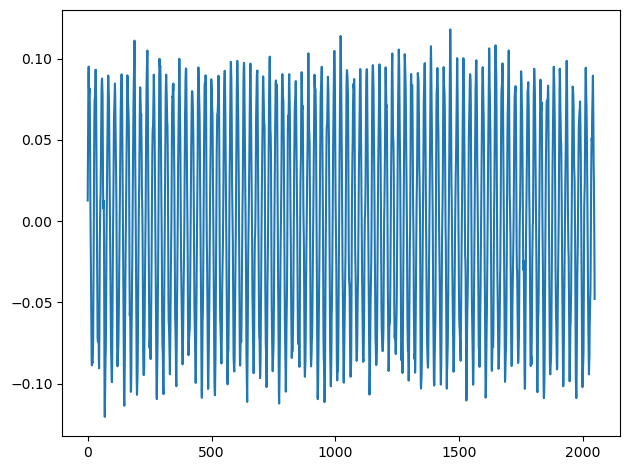

In [53]:
plt.plot(full_trace[0:])
plt.tight_layout()

# SNR

In [114]:
reader = readRNOGData()

reader.begin([f'/home/oliver/software/Flights/combined_handcarry/station11/run1313'], overwrite_sampling_rate=3200*units.MHz, apply_baseline_correction='approximate')

event = reader.get_event_by_index(173)
station = event.get_station()
channel = station.get_channel(13)
trace = channel.get_trace()

INFO:NuRadioReco.readRNOGData:Set 0 selector(s)
INFO:NuRadioReco.readRNOGData:Parse through / read-in 1 directory(ies) / file(s).
/home/oliver/anaconda3/envs/work/lib/python3.11/site-packages/mattak/Dataset.py:214: UserWarning: data_dir is deprecated, use data_path instead. This may be removed in the future, breaking your code.
  warnings.warn("data_dir is deprecated, use data_path instead. This may be removed in the future, breaking your code.")
INFO:NuRadioReco.readRNOGData:4773 events in 1 runs/datasets have been found using the uproot Mattak backend.


Using uproot backend
Open waveforms.root (Found full run folder) ...


RMS:  0.006335457071120628 max(trace):  0.2222250208707766 SNR:  35.076399125764894


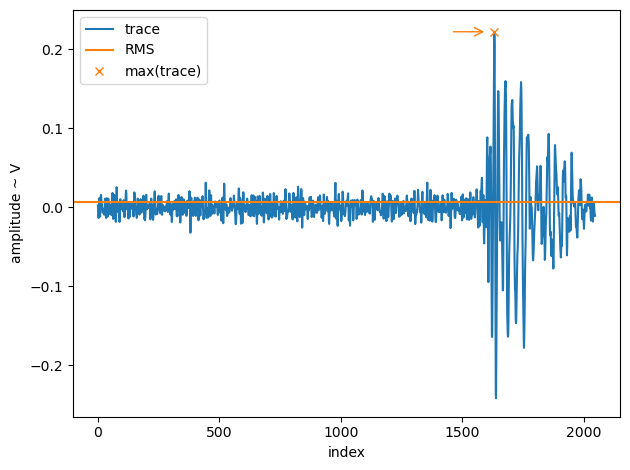

In [115]:
# get RMS
con = sqlite3.connect(f'./combined_scores_handcarry/station21_run1637_scores.db')    
RMSs = pd.read_sql_query("SELECT * FROM avg_RMS", con)
#scores = pd.read_sql_query("SELECT * FROM combined_scores", con)
#print(scores.columns)
RMS = np.array(RMSs.iloc[channel_number])[1] # get the RMS for channel = channel_number 

xlabel = 'index'
ylabel = 'amplitude ~ V'

ymax_index = np.argmax(trace)
print('RMS: ', RMS, 'max(trace): ', trace[ymax_index], 'SNR: ', trace[ymax_index] / RMS)

plt.plot(trace, label = 'trace')
plt.axhline(RMS, color = 'C1', label = 'RMS')# f'RMS = {RMS :.2e}')
plt.plot(ymax_index, trace[ymax_index], 'x', color = 'C1', label = 'max(trace)')

# Add a nicer-looking arrow
arrow = FancyArrowPatch(
    (ymax_index - 180, trace[ymax_index]),  # Starting point of the arrow
    (ymax_index - 30, trace[ymax_index]),   # Ending point of the arrow
    color='C1', 
    arrowstyle='->', 
    mutation_scale=15  # Size of the arrow head
)
plt.gca().add_patch(arrow)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.legend()
plt.tight_layout()
#plt.savefig('/home/oliver/thesis/figures/scores/SNR.pdf')

# Impulsivity

In [5]:
reader = readRNOGData()

reader.begin([f'/home/oliver/software/Flights/combined_handcarry/station11/run1313'], overwrite_sampling_rate=3200*units.MHz, apply_baseline_correction='approximate')

event = reader.get_event_by_index(192)
station = event.get_station()
channel = station.get_channel(13)
full_trace = channel.get_trace()

INFO:NuRadioReco.readRNOGData:Set 0 selector(s)
INFO:NuRadioReco.readRNOGData:Parse through / read-in 1 directory(ies) / file(s).
/home/oliver/anaconda3/envs/work/lib/python3.11/site-packages/mattak/Dataset.py:214: UserWarning: data_dir is deprecated, use data_path instead. This may be removed in the future, breaking your code.
  warnings.warn("data_dir is deprecated, use data_path instead. This may be removed in the future, breaking your code.")
INFO:NuRadioReco.readRNOGData:4773 events in 1 runs/datasets have been found using the uproot Mattak backend.


Using uproot backend
Open waveforms.root (Found full run folder) ...


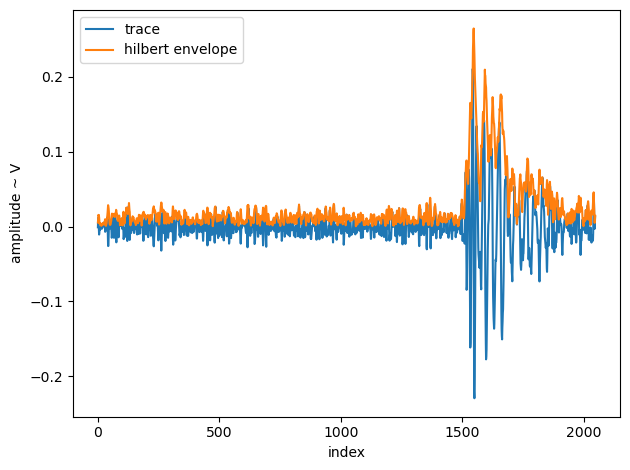

In [9]:
start_index = 0

trace = full_trace[start_index:]

abs_hilbert = abs(hilbert(trace))
hilbert_maximum_index = np.argmax(abs_hilbert)
reordered_index = np.argsort(abs(np.arange(len(trace))-hilbert_maximum_index))
reordered_hilbert = abs_hilbert[reordered_index]
impulsivity_curve = np.cumsum(reordered_hilbert)/np.sum(reordered_hilbert)
impulsivity = 2*np.mean(impulsivity_curve)-1    

plt.plot(trace, label = 'trace')
#plt.plot(- trace, '--', label = '- trace')
plt.plot(abs_hilbert, label = 'hilbert envelope')

xlabel = 'index'
ylabel = 'amplitude ~ V'

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.tight_layout()
#fig.savefig('/home/oliver/thesis/figures/scores/hilbert_envelope.png')

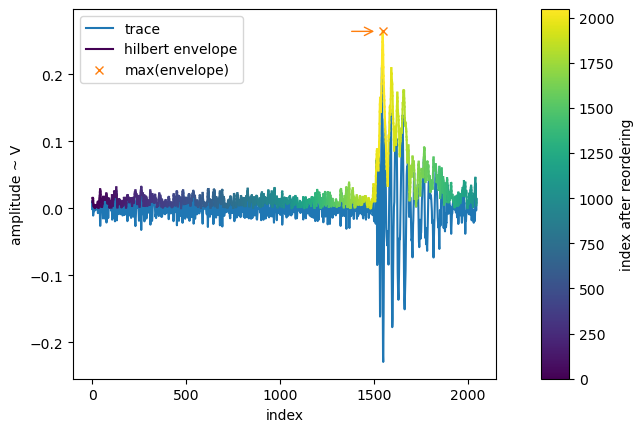

<Figure size 640x480 with 0 Axes>

In [10]:
y = abs_hilbert
x = range(len(trace))

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=min(x), vmax=max(x))

# Create a figure with a gridspec layout
fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[15, 1])

# Create the main plot
ax = fig.add_subplot(gs[0])

ax.plot(trace, color = 'C0',label = 'trace')
# Plot each segment with a different color
for i in range(len(x) - 1):
    index = reordered_index[i]
    ax.plot(x[index:index+2], y[index:index+2], color=cmap(norm(len(x)-i)))
    if i == 0:
        ax.plot([], color=cmap(norm(i)), label = 'hilbert envelope')

ymax_index = np.argmax(abs_hilbert)
plt.plot(ymax_index, abs_hilbert[ymax_index], 'x', color = 'C1', label = 'max(envelope)')

# Add a nicer-looking arrow
arrow = FancyArrowPatch(
    (ymax_index - 180, abs_hilbert[ymax_index]),  # Starting point of the arrow
    (ymax_index - 30, abs_hilbert[ymax_index]),   # Ending point of the arrow
    color='C1', 
    arrowstyle='->', 
    mutation_scale=15  # Size of the arrow head
)
plt.gca().add_patch(arrow)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# Create an axis for the colorbar
cax = fig.add_subplot(gs[1])

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar to the specified axis
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('index after reordering')

ax.legend()
plt.show()
plt.tight_layout()
#fig.savefig('/home/oliver/thesis/figures/scores/hilbert_envelope_colorful.pdf')

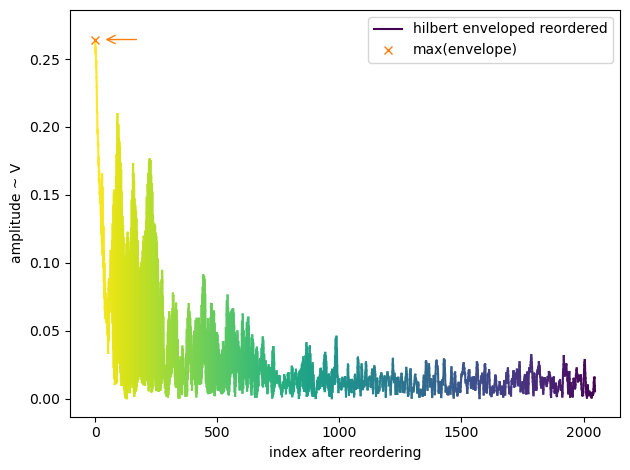

In [11]:
for i in range(len(x) - 1):
    index = i
    plt.plot(x[index:index+2], reordered_hilbert[index:index+2], color=cmap(norm(len(x)-i)))
    if i == 0:
        plt.plot([], color = cmap(norm(i)), label = 'hilbert enveloped reordered')
plt.xlabel('index after reordering')
plt.ylabel(ylabel)

ymax_index = np.argmax(reordered_hilbert)
plt.plot(ymax_index, reordered_hilbert[ymax_index], 'x', color = 'C1', label = 'max(envelope)')

# Add a nicer-looking arrow
arrow = FancyArrowPatch(
    (ymax_index + 180, reordered_hilbert[ymax_index]),  # Starting point of the arrow
    (ymax_index + 30, reordered_hilbert[ymax_index]),   # Ending point of the arrow
    color='C1', 
    arrowstyle='->', 
    mutation_scale=15  # Size of the arrow head
)
plt.gca().add_patch(arrow)

plt.legend()

plt.tight_layout()
#plt.savefig('/home/oliver/thesis/figures/scores/hilbert_envelope_reordered.pdf')

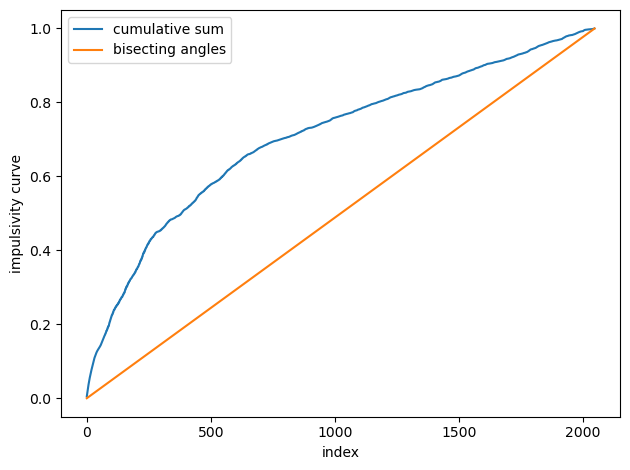

In [113]:
plt.plot(impulsivity_curve, label = 'cumulative sum')
plt.plot([0, len(trace)], [0, 1], label = 'bisecting angles')
xlabel = 'index'
ylabel = 'impulsivity curve'


plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.tight_layout()
#plt.savefig('/home/oliver/thesis/figures/scores/impulsivity_curve.pdf')

# Planes

In [ ]:
tracker = FlightTracker()